In [64]:
# 첫 번째 셀: 필요한 라이브러리 임포트
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from datetime import datetime, timedelta

In [65]:
# 두 번째 셀: 데이터 다운로드 및 전처리
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

print("Downloading QQQ data...")
qqq = yf.download('QQQ', start=start_date, end=end_date)
print("Downloading TQQQ data...")
tqqq = yf.download('TQQQ', start=start_date, end=end_date)
print("Downloading VIX data...")
vix = yf.download('^VIX', start=start_date, end=end_date)
print("Downloading Treasury data...")
tbill = yf.download('^IRX', start=start_date, end=end_date)
treasury = yf.download('^TNX', start=start_date, end=end_date)

common_idx = qqq.index.intersection(tqqq.index).intersection(vix.index)
qqq = qqq.loc[common_idx]
tqqq = tqqq.loc[common_idx]
vix = vix.loc[common_idx]

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [66]:
# 세 번째 셀: 개선된 특성 엔지니어링
print("Initial data shapes:")
print("QQQ shape:", qqq.shape)
print("TQQQ shape:", tqqq.shape)
print("VIX shape:", vix.shape)
print("Common index length:", len(common_idx))

# 데이터프레임 생성
df = pd.DataFrame(index=common_idx)

# 기본 수익률
df['qqq_return'] = qqq['Close'].pct_change()
df['tqqq_return'] = tqqq['Close'].pct_change()

# TQQQ 특성
df['tqqq_vol'] = tqqq['Volume']
df['tqqq_price'] = tqqq['Close']
df['tqqq_high_low'] = (tqqq['High'] - tqqq['Low']) / tqqq['Close']
df['tqqq_gap'] = (tqqq['Open'] / tqqq['Close'].shift(1) - 1)

# 개선된 TQQQ 특성
df['tqqq_price_to_ma5'] = tqqq['Close'] / tqqq['Close'].rolling(window=5, min_periods=1).mean()
df['tqqq_price_to_ma20'] = tqqq['Close'] / tqqq['Close'].rolling(window=20, min_periods=1).mean()
df['tqqq_volume_ratio'] = tqqq['Volume'] / tqqq['Volume'].rolling(window=20, min_periods=1).mean()
df['tqqq_momentum_5d'] = tqqq['Close'].pct_change(5)
df['tqqq_momentum_10d'] = tqqq['Close'].pct_change(10)
df['tqqq_momentum_20d'] = tqqq['Close'].pct_change(20)

# TQQQ 변동성 특성
df['tqqq_volatility'] = df['tqqq_return'].rolling(window=20, min_periods=1).std()
df['tqqq_volatility_ratio'] = df['tqqq_volatility'] / df['tqqq_volatility'].rolling(window=60, min_periods=1).mean()
df['tqqq_high_low_ratio'] = df['tqqq_high_low'] / df['tqqq_high_low'].rolling(window=20, min_periods=1).mean()

# VIX 관련 특성
df['vix'] = vix['Close']
df['vix_change'] = df['vix'].pct_change()
df['vix_ma5'] = df['vix'].rolling(window=5, min_periods=1).mean()
df['vix_ma20'] = df['vix'].rolling(window=20, min_periods=1).mean()
df['vix_ratio'] = df['vix'] / df['vix_ma20']
df['vix_term_structure'] = df['vix'] - df['vix_ma20']
df['vix_momentum_5d'] = df['vix'].pct_change(5)
df['vix_momentum_10d'] = df['vix'].pct_change(10)
df['vix_volatility'] = df['vix_change'].rolling(window=20, min_periods=1).std()
df['vix_volatility_ratio'] = df['vix_volatility'] / df['vix_volatility'].rolling(window=60, min_periods=1).mean()

# 개선된 자금 조달 비용 계산
df['tbill_3m'] = tbill['Close'].reindex(common_idx, method='ffill') / 100
df['treasury_10y'] = treasury['Close'].reindex(common_idx, method='ffill') / 100
df['yield_spread'] = df['treasury_10y'] - df['tbill_3m']
df['yield_curve_slope'] = df['yield_spread'] / df['tbill_3m']
df['yield_momentum'] = df['treasury_10y'].pct_change(5)

# 개선된 VIX 레짐 기반 동적 자금 조달 비용
df['vix_regime'] = pd.qcut(df['vix'].fillna(df['vix'].mean()),
                           q=7, labels=[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3])
df['funding_cost_base'] = (df['tbill_3m'] * 2 +
                           df['yield_spread'] * 0.15 +
                           df['vix_momentum_5d'].abs() * 0.08 +
                           df['yield_momentum'].abs() * 0.05) * df['vix_regime'].astype(float)
df['vix_cost_adj'] = (df['vix'] / 16) * 0.0001 * (1 +
                                                  df['vix_term_structure'].abs() +
                                                  df['vix_momentum_5d'].abs() +
                                                  df['vix_volatility_ratio'])
df['total_funding_cost'] = (df['funding_cost_base'] + df['vix_cost_adj']) / 252

# 실제 레버리지 계산 및 클리핑
mask = df['qqq_return'] != 0
df['leverage_ratio'] = pd.Series(index=df.index)
df.loc[mask, 'leverage_ratio'] = (df.loc[mask, 'tqqq_return'] + df.loc[mask, 'total_funding_cost']) / df.loc[mask, 'qqq_return']
df.loc[~mask, 'leverage_ratio'] = 3.0
df['leverage_ratio'] = df['leverage_ratio'].clip(2.990, 3.010)

# 추가된 레버리지 특성
windows = [3, 5, 10, 15, 20, 30]
for window in windows:
    # 레버리지 지표
    df[f'leverage_ma_{window}d'] = df['leverage_ratio'].rolling(window=window, min_periods=1).mean()
    df[f'leverage_std_{window}d'] = df['leverage_ratio'].rolling(window=window, min_periods=1).std()

    # TQQQ 지표
    df[f'tqqq_ma_{window}d'] = df['tqqq_price'].rolling(window=window, min_periods=1).mean()
    df[f'tqqq_vol_{window}d'] = df['tqqq_return'].rolling(window=window, min_periods=1).std()
    df[f'tqqq_volume_ma_{window}d'] = df['tqqq_vol'].rolling(window=window, min_periods=1).mean()

    # VIX 지표
    df[f'vix_vol_{window}d'] = df['vix_change'].rolling(window=window, min_periods=1).std()

    # RSI 계산
    up_returns = pd.Series(np.where(df['tqqq_return'] > 0, df['tqqq_return'], 0), index=df.index)
    down_returns = pd.Series(np.where(df['tqqq_return'] < 0, -df['tqqq_return'], 0), index=df.index)

    avg_up = up_returns.rolling(window=window, min_periods=1).mean()
    avg_down = down_returns.rolling(window=window, min_periods=1).mean()

    df[f'rsi_{window}d'] = np.where(avg_down == 0, 100, 100 - (100 / (1 + avg_up / avg_down)))

# 시장 상태 지표
df['market_stress'] = ((df['vix'] > df['vix_ma20']) &
                       (df['tqqq_volatility'] > df['tqqq_volatility'].rolling(window=20, min_periods=1).mean())).astype(float)
df['trend_strength'] = abs(df['tqqq_ma_20d'] - df['tqqq_ma_5d']) / df['tqqq_price']
df['market_regime'] = (df['market_stress'] * (df['vix'] > df['vix'].rolling(window=60, min_periods=1).mean())).astype(float)

# 무한값을 NaN으로 변환
df = df.replace([np.inf, -np.inf], np.nan)

# 결측치 처리 전 상태 출력
print("\nShape before cleaning:", df.shape)
print("\nColumns with null values:", df.isnull().sum()[df.isnull().sum() > 0])

# 처음 30일 데이터 제외
df = df.iloc[30:]

# 결측치 처리
df = df.ffill().bfill()

# 최종 상태 출력
print("\nShape after cleaning:", df.shape)
print("\nSample of final data:")
print(df.head())

Initial data shapes:
QQQ shape: (2513, 5)
TQQQ shape: (2513, 5)
VIX shape: (2513, 5)
Common index length: 2513

Shape before cleaning: (2513, 80)

Columns with null values: qqq_return                1
tqqq_return               1
tqqq_gap                  1
tqqq_momentum_5d          5
tqqq_momentum_10d        10
tqqq_momentum_20d        20
tqqq_volatility           2
tqqq_volatility_ratio     2
vix_change                1
vix_momentum_5d           5
vix_momentum_10d         10
vix_volatility            2
vix_volatility_ratio      2
yield_momentum            5
funding_cost_base         5
vix_cost_adj              5
total_funding_cost        5
leverage_ratio            5
leverage_ma_3d            5
leverage_std_3d           6
tqqq_vol_3d               2
vix_vol_3d                2
leverage_ma_5d            5
leverage_std_5d           6
tqqq_vol_5d               2
vix_vol_5d                2
leverage_ma_10d           5
leverage_std_10d          6
tqqq_vol_10d              2
vix_vol_10d    

In [67]:
# 네 번째 셀: 데이터 준비
# 특성 선택 (market_regime 제외)
seq_length = 10
features = [col for col in df.columns if col not in ['leverage_ratio', 'tqqq_return', 'market_regime']]

print("Initial DataFrame shape:", df.shape)
print("Number of features:", len(features))

# 시퀀스 데이터 생성
X, y = [], []

print("\nCreating sequences...")
for i in range(len(df) - seq_length):
    feature_sequence = df[features].iloc[i:(i + seq_length)].values
    target_value = df['leverage_ratio'].iloc[i + seq_length]
    X.append(feature_sequence)
    y.append(target_value)

X = np.array(X)
y = np.array(y)

print("\nSequence data shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# 데이터 분할
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 스케일링
scaler = RobustScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print("\nFinal shapes after scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# 데이터 샘플 확인
print("\nSample of first sequence:")
print("X first sequence shape:", X[0].shape)
print("y first value:", y[0])

# 특성 이름 출력
print("\nFeatures used:")
for i, feature in enumerate(features):
    print(f"{i+1}. {feature}")

# 메모리 사용량 최적화
import gc
gc.collect()

Initial DataFrame shape: (2483, 80)
Number of features: 77

Creating sequences...

Sequence data shapes:
X shape: (2473, 10, 77)
y shape: (2473,)

Final shapes after scaling:
X_train_scaled shape: (1978, 10, 77)
X_test_scaled shape: (495, 10, 77)
y_train shape: (1978,)
y_test shape: (495,)

Sample of first sequence:
X first sequence shape: (10, 77)
y first value: 3.01

Features used:
1. qqq_return
2. tqqq_vol
3. tqqq_price
4. tqqq_high_low
5. tqqq_gap
6. tqqq_price_to_ma5
7. tqqq_price_to_ma20
8. tqqq_volume_ratio
9. tqqq_momentum_5d
10. tqqq_momentum_10d
11. tqqq_momentum_20d
12. tqqq_volatility
13. tqqq_volatility_ratio
14. tqqq_high_low_ratio
15. vix
16. vix_change
17. vix_ma5
18. vix_ma20
19. vix_ratio
20. vix_term_structure
21. vix_momentum_5d
22. vix_momentum_10d
23. vix_volatility
24. vix_volatility_ratio
25. tbill_3m
26. treasury_10y
27. yield_spread
28. yield_curve_slope
29. yield_momentum
30. vix_regime
31. funding_cost_base
32. vix_cost_adj
33. total_funding_cost
34. leverag

27518

In [68]:
# 다섯 번째 셀: 개선된 모델 정의
class OutputScaling(tf.keras.layers.Layer):
    def __init__(self, min_val=2.990, max_val=3.010, **kwargs):
        super(OutputScaling, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val

    def call(self, inputs):
        return inputs * (self.max_val - self.min_val) + self.min_val

    def get_config(self):
        config = super(OutputScaling, self).get_config()
        config.update({
            'min_val': self.min_val,
            'max_val': self.max_val
        })
        return config

def tqqq_focused_loss(y_true, y_pred):
    # 기본 MSE
    mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # 레버리지 범위 페널티
    range_penalty = tf.reduce_mean(
        tf.maximum(0., 2.990 - y_pred) + tf.maximum(0., y_pred - 3.010)
    )

    # 레버리지 추적 페널티
    tracking_penalty = tf.reduce_mean(tf.abs(y_true - y_pred))

    # 변동성 페널티
    vol_penalty = tf.abs(
        tf.math.reduce_std(y_true) - tf.math.reduce_std(y_pred)
    )

    # 상관관계 페널티
    correlation = tf.abs(tf.reduce_mean((y_true - tf.reduce_mean(y_true)) *
                                        (y_pred - tf.reduce_mean(y_pred)))) / (
                          tf.math.reduce_std(y_true) * tf.math.reduce_std(y_pred) + 1e-6)
    correlation_penalty = 1 - correlation

    # 방향성 페널티
    direction_penalty = tf.reduce_mean(
        tf.abs(tf.sign(y_true - tf.reduce_mean(y_true)) -
               tf.sign(y_pred - tf.reduce_mean(y_pred)))
    )

    return (mse +
            100.0 * range_penalty +
            60.0 * tracking_penalty +
            40.0 * vol_penalty +
            50.0 * correlation_penalty +
            30.0 * direction_penalty)

def create_model(seq_length, n_features):
    inputs = tf.keras.layers.Input(shape=(seq_length, n_features))

    # 초기 특성 처리
    x = tf.keras.layers.Dense(384)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    residual = x

    # 첫 번째 Attention 블록
    attention1 = tf.keras.layers.MultiHeadAttention(
        num_heads=16, key_dim=64
    )(x, x)
    x = tf.keras.layers.LayerNormalization()(attention1 + residual)
    x = tf.keras.layers.Dropout(0.2)(x)

    # 첫 번째 LSTM 블록
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(384, return_sequences=True)
    )(x)
    lstm1 = tf.keras.layers.LayerNormalization()(lstm1)
    lstm1 = tf.keras.layers.Dropout(0.2)(lstm1)
    residual = lstm1

    # 두 번째 Attention 블록
    attention2 = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=48
    )(lstm1, lstm1)
    x = tf.keras.layers.LayerNormalization()(attention2 + residual)
    x = tf.keras.layers.Dropout(0.2)(x)

    # 두 번째 LSTM 블록
    lstm2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True)
    )(x)
    lstm2 = tf.keras.layers.LayerNormalization()(lstm2)
    lstm2 = tf.keras.layers.Dropout(0.2)(lstm2)

    # 세 번째 LSTM 블록
    x = tf.keras.layers.LSTM(192)(lstm2)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Dense 레이어
    x = tf.keras.layers.Dense(256, activation='swish')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(128, activation='swish')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 출력 레이어
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs = OutputScaling(min_val=2.990, max_val=3.010)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [69]:
# 여섯 번째 셀: 개선된 모델 학습
# Learning rate scheduler 정의
initial_learning_rate = 0.00008
warmup_epochs = 10
decay_epochs = 190
total_epochs = warmup_epochs + decay_epochs

def learning_rate_scheduler(epoch):
    if epoch < warmup_epochs:
        return initial_learning_rate * ((epoch + 1) / warmup_epochs)
    else:
        return initial_learning_rate * (0.5 ** ((epoch - warmup_epochs) / 50))

# 모델 생성 및 컴파일
model = create_model(seq_length, len(features))
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    beta_1=0.91,
    beta_2=0.9995,
    epsilon=1e-8
)

# Gradient Clipping 추가
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    beta_1=0.91,
    beta_2=0.9995,
    epsilon=1e-8,
    clipnorm=1.0  # Gradient clipping norm
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        min_delta=1e-6
    ),
    tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=25,
        min_lr=0.00001,
        min_delta=1e-6
    )
]

model.compile(optimizer=optimizer,
              loss=tqqq_focused_loss,
              metrics=['mae'])

# 모델 학습
history = model.fit(
    X_train_scaled, y_train,
    epochs=total_epochs,
    batch_size=20,
    validation_split=0.12,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - loss: 73.4602 - mae: 0.0101 - val_loss: 71.7244 - val_mae: 0.0101 - learning_rate: 8.0000e-06
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - loss: 73.3548 - mae: 0.0098 - val_loss: 73.0600 - val_mae: 0.0108 - learning_rate: 1.6000e-05
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 72.9604 - mae: 0.0098 - val_loss: 75.8840 - val_mae: 0.0104 - learning_rate: 2.4000e-05
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - loss: 72.3480 - mae: 0.0096 - val_loss: 72.9039 - val_mae: 0.0109 - learning_rate: 3.2000e-05
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - loss: 69.0743 - mae: 0.0094 - val_loss: 76.5939 - val_mae: 0.0114 - learning_rate: 4.0000e-05
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - loss: 72.3847 - mae: 0.0097 - val_loss: 77.9854 - val_mae: 0.0119 - learning_rate: 4.8000e-05
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - loss: 70.0655 - mae: 0.0097 - val_loss: 76.9

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


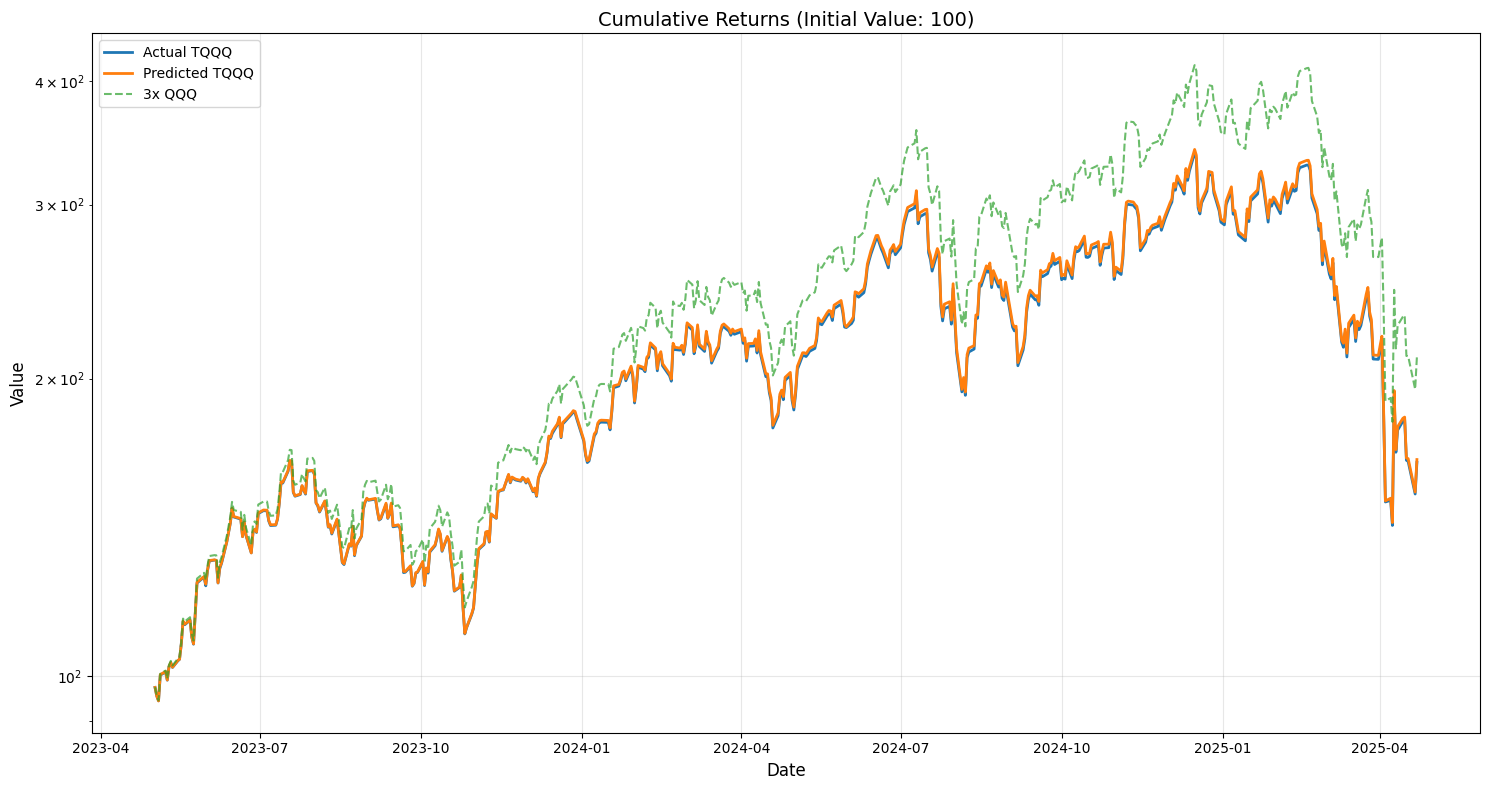


Performance Analysis:
Initial Value: 100

Final Values:
Actual TQQQ: 164.49
Predicted TQQQ: 165.59
3x QQQ: 210.45

Total Returns:
Actual TQQQ: 64.49%
Predicted TQQQ: 65.59%
3x QQQ: 110.45%

Leverage Analysis:
Average Actual Leverage: 2.9986
Average Predicted Leverage: 3.0027
Leverage Correlation: -0.0388

Market Environment Analysis:
Average Interest Rate: 4.93%
Average VIX: 16.46
Average Daily Funding Cost: 0.0488%

Returns Correlation: 0.9997
Annualized Tracking Error: 1.62%

Additional Metrics:
Daily Volatility (Actual TQQQ): 62.78%
Daily Volatility (Predicted TQQQ): 63.52%
Maximum Drawdown (Actual TQQQ): 58.04%
Maximum Drawdown (Predicted TQQQ): 58.10%


In [70]:
# 일곱 번째 셀: 성과 평가
leverage_pred = model.predict(X_test_scaled)
test_data = df.iloc[split_idx + seq_length:]
predicted_returns = test_data['qqq_return'].values * leverage_pred.flatten() - test_data['total_funding_cost'].values

def calculate_cumulative_returns(returns, initial_value=100):
    returns = pd.Series(returns)
    cumulative_value = initial_value * (1 + returns).cumprod()
    return cumulative_value

initial_value = 100
actual_tqqq = calculate_cumulative_returns(test_data['tqqq_return'], initial_value)
predicted_tqqq = calculate_cumulative_returns(predicted_returns, initial_value)
qqq_3x = calculate_cumulative_returns(test_data['qqq_return'] * 3, initial_value)

plt.figure(figsize=(15, 8))
plt.plot(test_data.index, actual_tqqq, label='Actual TQQQ', linewidth=2)
plt.plot(test_data.index, predicted_tqqq, label='Predicted TQQQ', linewidth=2)
plt.plot(test_data.index, qqq_3x, label='3x QQQ', linestyle='--', alpha=0.7)
plt.title('Cumulative Returns (Initial Value: 100)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("\nPerformance Analysis:")
print(f"Initial Value: {initial_value}")
print(f"\nFinal Values:")
print(f"Actual TQQQ: {actual_tqqq.iloc[-1]:.2f}")
print(f"Predicted TQQQ: {predicted_tqqq.iloc[-1]:.2f}")
print(f"3x QQQ: {qqq_3x.iloc[-1]:.2f}")

print("\nTotal Returns:")
print(f"Actual TQQQ: {(actual_tqqq.iloc[-1]/initial_value - 1):.2%}")
print(f"Predicted TQQQ: {(predicted_tqqq.iloc[-1]/initial_value - 1):.2%}")
print(f"3x QQQ: {(qqq_3x.iloc[-1]/initial_value - 1):.2%}")

print("\nLeverage Analysis:")
print(f"Average Actual Leverage: {np.mean(test_data['leverage_ratio']):.4f}")
print(f"Average Predicted Leverage: {np.mean(leverage_pred):.4f}")
print(f"Leverage Correlation: {np.corrcoef(test_data['leverage_ratio'], leverage_pred.flatten())[0,1]:.4f}")

print("\nMarket Environment Analysis:")
print(f"Average Interest Rate: {np.mean(test_data['tbill_3m'])*100:.2f}%")
print(f"Average VIX: {np.mean(test_data['vix']):.2f}")
print(f"Average Daily Funding Cost: {np.mean(test_data['total_funding_cost'])*100:.4f}%")

print(f"\nReturns Correlation: {np.corrcoef(test_data['tqqq_return'], predicted_returns)[0,1]:.4f}")
print(f"Annualized Tracking Error: {np.std(test_data['tqqq_return'] - predicted_returns) * np.sqrt(252):.2%}")

print("\nAdditional Metrics:")
print(f"Daily Volatility (Actual TQQQ): {np.std(test_data['tqqq_return'])*np.sqrt(252):.2%}")
print(f"Daily Volatility (Predicted TQQQ): {np.std(predicted_returns)*np.sqrt(252):.2%}")
print(f"Maximum Drawdown (Actual TQQQ): {(1 - actual_tqqq/actual_tqqq.cummax()).max():.2%}")
print(f"Maximum Drawdown (Predicted TQQQ): {(1 - predicted_tqqq/predicted_tqqq.cummax()).max():.2%}")

In [71]:
# 여덟 번째 셀: 모델 저장
model_save_path = 'leverage_model.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

import joblib
scaler_save_path = 'leverage_scaler.pkl'
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

import json
feature_save_path = 'feature_names.json'
feature_names = {
    'features': features,
    'seq_length': seq_length
}
with open(feature_save_path, 'w') as f:
    json.dump(feature_names, f)
print(f"Feature names saved to {feature_save_path}")

Model saved to leverage_model.keras
Scaler saved to leverage_scaler.pkl
Feature names saved to feature_names.json
